c:\Users\juanc\Documents\Estudio\Visual Programacion\Prediction and Analysis de Compras Publicas\.venv\Lib\site-packages\fsspec\registry.py:294: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)
C:\Users\juanc\AppData\Local\Temp\ipykernel_12112\4006672430.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('s3://secop-public-procurement-dataset/secop_data_cleaned.csv')


0    prestación de servicios profesionales para apo...
1    prestar servicios profesionales para gestionar...
2    prestacion de servicios profesionales como aux...
3    prestar sus servicios como apoyo a la gestion ...
4    pobreza_2019_egit_th_tu prestación de servicio...
Name: objeto_a_contratar, dtype: object
Número de registros: 90289
Longitud promedio: 247.02544052985414


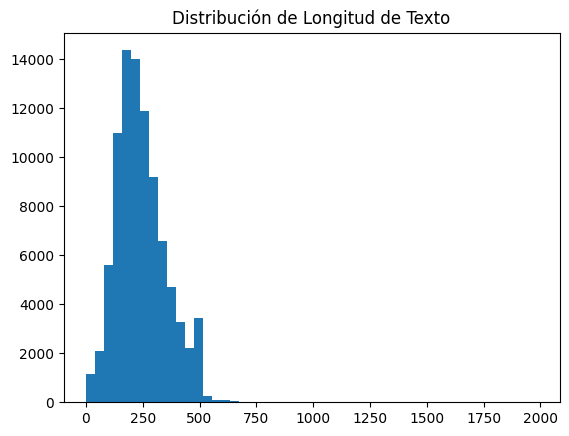

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos desde S3
df = pd.read_csv('s3://secop-public-procurement-dataset/secop_data_cleaned.csv')

# Explorar el campo de texto
print(df['objeto_a_contratar'].head())
print(f"Número de registros: {len(df)}")

# Longitud promedio del texto
df['text_length'] = df['objeto_a_contratar'].str.len()
print(f"Longitud promedio: {df['text_length'].mean()}")

# Visualizar distribución de longitudes
plt.hist(df['text_length'], bins=50)
plt.title("Distribución de Longitud de Texto")
plt.show()


count    9.028900e+04
mean     2.984361e+08
std      2.902339e+10
min      1.000000e+00
25%      9.000000e+06
50%      1.841940e+07
75%      3.769236e+07
max      7.840000e+12
Name: valor_contrato, dtype: float64


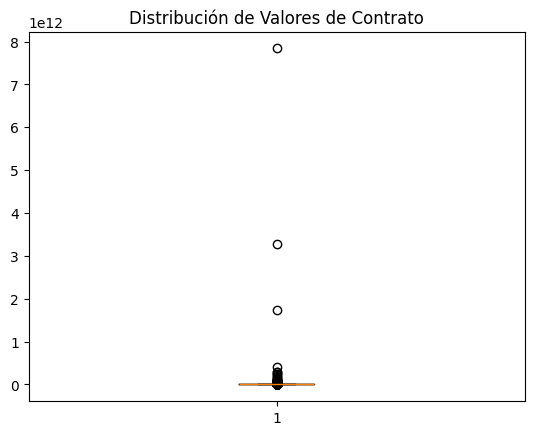

                                    nombre_de_la_entidad  valor_contrato
70984  subred integrada de servicios de salud sur e.s.e.   7840000000000
60577                                igac sede central *   3286969000000
18262             ministerio de educacion nacional (men)   1737035145293
49885         agencia logistica de las fuerzas militares    398349443553
62919                                             invias    296124698574


In [2]:
# Estadísticas básicas
print(df['valor_contrato'].describe())

# Boxplot para detectar outliers
plt.boxplot(df['valor_contrato'].dropna())
plt.title("Distribución de Valores de Contrato")
plt.show()

# Top 5 contratos más caros
print(df.nlargest(5, 'valor_contrato')[['nombre_de_la_entidad', 'valor_contrato']])

C:\Users\juanc\AppData\Local\Temp\ipykernel_3800\2131162113.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=phrases_series.index, x=phrases_series.values, palette='magma')


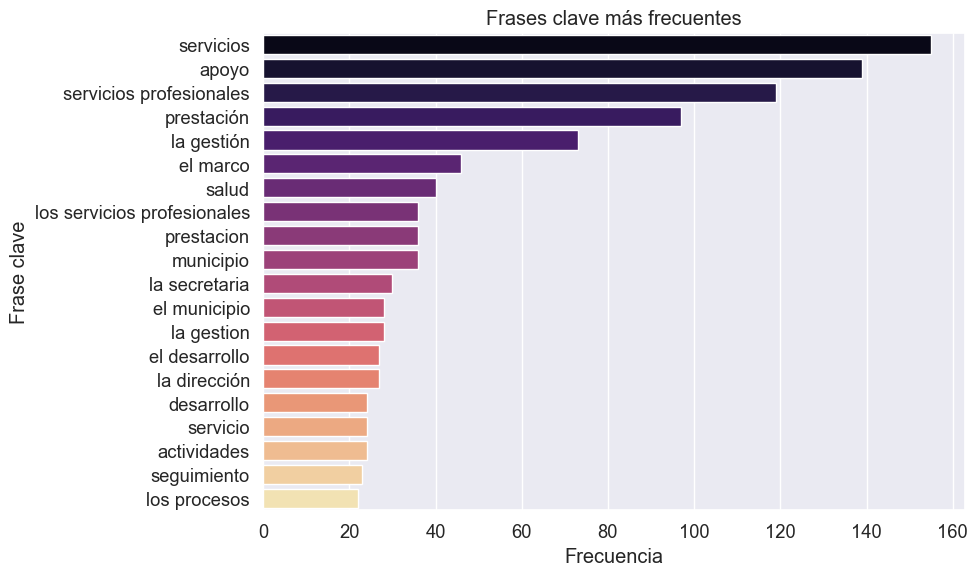

C:\Users\juanc\AppData\Local\Temp\ipykernel_3800\2131162113.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=entities_series.index, x=entities_series.values, palette='viridis')


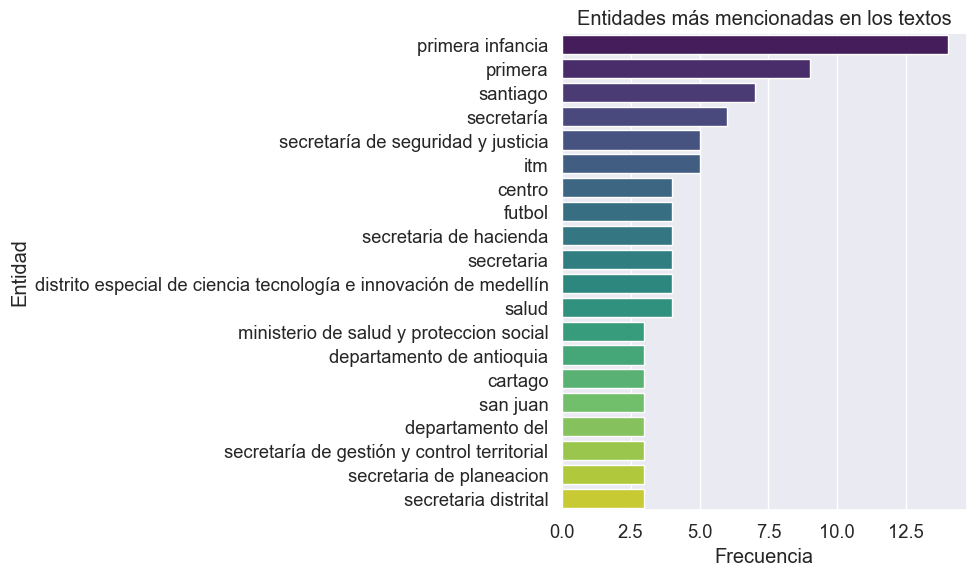

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import ast
import re

plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# ============================
# CARGA Y LIMPIEZA DE DATOS
# ============================

df = pd.read_csv("s3://secop-public-procurement-dataset/secop_nlp_analysis.csv")

# Si vienen como strings de listas, parsearlas

def safe_eval(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except:
        return []

df['entities_text'] = df['entities_text'].apply(safe_eval)
df['key_phrases_text'] = df['key_phrases_text'].apply(safe_eval)

# ============================
# FILTRADO DE ENTIDADES
# ============================

palabras_excluir = {
    'bogotá', 'cundinamarca', 'santander', 'santiago de cali', 'cali', 'antioquia', 'nariño', 'meta', 'tolima', 
    "valle del cauca", "de", "colombia", "medellin", "bucaramanga", "municipio", "bolívar", "cauca", 
    "departamento del valle del cauca", "oriente", "villavicencio", "boyaca", "de santander", "medellín", 
    "baranquilla", "sur occidente", "centro oriente", "narino", "neiva", "nacional",
    "barranquilla", "departamento de santander", "cartagena", "pereira", "yopal", "popayán", "tuluá"
}

def limpiar_entidades(entidades):
    clean = []
    for e in entidades:
        e_lower = str(e).lower().strip()
        if not e_lower.isdigit() and e_lower not in palabras_excluir:
            clean.append(e)
    return clean

df['entities_text'] = df['entities_text'].apply(limpiar_entidades)

# ============================
# ANÁLISIS EXPLORATORIO
# ============================

# Frases clave más comunes
all_phrases = sum(df['key_phrases_text'].tolist(), [])
phrases_series = pd.Series(all_phrases).value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(y=phrases_series.index, x=phrases_series.values, palette='magma')
plt.title("Frases clave más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Frase clave")
plt.tight_layout()
plt.show()

# Entidades más mencionadas
all_entities = sum(df['entities_text'].tolist(), [])
entities_series = pd.Series(all_entities).value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(y=entities_series.index, x=entities_series.values, palette='viridis')
plt.title("Entidades más mencionadas en los textos")
plt.xlabel("Frecuencia")
plt.ylabel("Entidad")
plt.tight_layout()
plt.show()

# Exportar resumen
df_summary = pd.DataFrame({
    'frase_clave': phrases_series.index,
    'frecuencia': phrases_series.values
})